# Clustering Countries - Indirect Effects

In [1]:
%matplotlib notebook

from IPython.display import display_html 

from tools import Preprocessing, Clustering, benchClustering, plotBarh

import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan

from scipy.cluster import hierarchy


from fancyimpute import KNN
from fancyimpute import MICE
from fancyimpute.bayesian_ridge_regression import BayesianRidgeRegression

import matplotlib as mpl
import matplotlib.pyplot as plt
import bqplot as bqp
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pylab

import ipyvolume as ipv
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink


sns.set(context='notebook', style='whitegrid', font='sans-serif',
        palette='muted', font_scale=1, color_codes=True, rc=None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 10000)

Using TensorFlow backend.


In [2]:
on_PC = 0
n_init = 10

In [3]:
# import the csv dataset as a pandas DataFrame
# df = pd.read_csv('data/full_data.csv')
#df.columns
# list(df.columns)

**Indirect effects** occur to industries in the backward­linked industries that supply the exporting firm. [Wayne P. Miller]

Il valore dei moltiplicatori d'impatto indiretto dipende da:
 - Sviluppo del settore petrolifero, che incide sulla disponibilità di suppliers specializzati
     - Produzione di petrolio (bdp)
     - Produzione di petrolio (bdp)/GDP(US$)? In realtà, ciò che ci interessa è il valore assoluto della produzione, non relativo alla ricchezza totale del paese.
     - Numero di siti di estrazione?
 - Sviluppo industriale di un paese. (I suppliers avranno bisogno di materie prime, lavorazioni di vario genere, trasporti etc.)
 - Livello di importazione: più un paese è propenso all'importazione, meno la spesa dei suppliers sarà rivolta internamente al paese.


In [4]:
varlist = [
    'Production_Oil_bpd_2016',
    'ImportGoodsServices_%GDP',
    'MVAsh%_2015',
#    'MVApc_constantUS$_2015',
#   'Production_Oil_bpd_2014',
#   'Production_Oil_bpd_2015',
#   'MHMVAsh%_2015',
          ]

In [5]:
prep = Preprocessing('data/full_data.csv',
                     varlist=varlist, verbose=True)
prep.exportCSV('data/cleaned_data_petroleum.csv', impute=True)

MISSING VALUES FOR EACH FEATURE:
MVAsh%_2015                 3
ImportGoodsServices_%GDP    1
dtype: int64 

MISSING VALUES FOR EACH COUNTRY:
Country Code
TKM    2
TLS    1
LBY    1
dtype: int64


In [6]:
# for c in prep.df.columns[1:]:
#     plotBarh(df=prep.df, by_column=c )

In [7]:
data = Clustering('data/cleaned_data_petroleum.csv', verbose=False)
data.getPC()
data.plotAlongPC(pc1=0, pc2=1, xlim=[-3, 3], ylim=[-2, 2])

CUMULATIVE PROPORTION OF VARIANCE EXPLAINED BY PCs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
x = data.df.iloc[:, 0]
y = data.df.iloc[:, 1]
z = data.df.iloc[:, 2]
print('x = ', x.name)
print('y = ', y.name)
print('z = ', z.name)

selected = None
ipv.figure()
scatter = ipv.pylab.scatter(x, y, z, marker="sphere", color = 'green', size=5, size_selected=8, selected=selected)
# ipv.pylab.xyzlabel(x.name, y.name, z.name)

size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((scatter, 'size'), (size, 'value'))
jslink((scatter, 'size_selected'), (size_selected, 'value'))
jslink((scatter, 'color'), (color, 'value'))
jslink((scatter, 'color_selected'), (color_selected, 'value'))
VBox([ipv.gcc(), size, size_selected, color, color_selected])

x =  Production_Oil_bpd_2016
y =  ImportGoodsServices_%GDP
z =  MVAsh%_2015


In [9]:
k_min = 5
k_max = 30
silh, calha = data.multipleKmeans(k_min=5, k_max=30, on_PC=0, n_init=n_init)

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [10]:
k_clusters = 10
data.kmeans(n_clusters=k_clusters, on_PC=on_PC)
# data.clusterings['kmeans'+str(n_clusters)]

In [11]:
data.gmBIC(n_min=1, n_max=30, covariance_type='full', n_init=n_init, on_PC=on_PC)

the minimum BIC is achieved with               23 gaussian components


<IPython.core.display.Javascript object>

In [12]:
n_components = 21
data.gaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)
data.bayesianGaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)

In [13]:
data.hierarchicalClustering(metric='euclidean', method='ward', threshold=1.5, on_PC=0, heatmap=False)

Hierarchical clustering with euclidean distance metric.


<IPython.core.display.Javascript object>

In [14]:
data.hierarchicalClustering(metric='euclidean', method='complete', threshold=1.5, on_PC=on_PC, heatmap=False)

Hierarchical clustering with euclidean distance metric.


<IPython.core.display.Javascript object>

In [15]:
# display all clusters together
# newdf = np.zeros(len(data.clusterings.keys()))
styler = []
for k in data.clusterings.keys():
    styler.append(data.clusterings[k].style.set_table_attributes("style='display:inline'"))
display_html(styler[0]._repr_html_() + styler[1]._repr_html_() + styler[2]._repr_html_() + styler[3]._repr_html_() + styler[4]._repr_html_(), raw=True)

,hierarchical_ward_euclidean
Cluster,
1,['China']
2,['United States']
3,"['Mexico', 'Venezuela RB']"
4,"['Egypt', 'Indonesia']"
5,"[""Cote d'Ivoire"", 'Ecuador', 'Italy', 'Kenya', 'Pakistan', 'South Africa', 'Timor-Leste']"
6,"['Lebanon', 'Morocco', 'Portugal', 'Tunisia']"
7,"['Algeria', 'Angola', 'Australia', 'Gabon', 'Kazakhstan', 'Nigeria', 'Norway', 'Oman', 'United Kingdom']"
8,['Iraq']
9,['United Arab Emirates']


In [16]:
# data.hdbscan(min_cluster_size=2, on_PC=0)
# data.clusterings['hdbscan']

In [19]:
data.clusterings_labels['gm21']

array([16, 16, 18,  2, 19,  4, 15, 20, 10, 18,  0, 12,  5, 14, 10,  9,  4,
       17,  1,  3, 15, 11,  7, 13, 16,  9, 20,  4,  4,  4, 11,  0,  8,  9,
        6,  3, 14])

In [17]:
cyple_list = cycle(plt.rcParams['axes.color_cycle'])

NameError: name 'cycle' is not defined

In [ ]:
next(ccc)

In [ ]:
from itertools import cycle

cycled_list = cycle(list('rgby'))
for x in range(10):
    print(next(cycled_list))

In [ ]:
import matplotlib
matplotlib.__version__

In [ ]:
for c in plt.rcParams['axes.color_cycle']

In [ ]:
# build a generator of colors
cm = pylab.get_cmap('gist_rainbow')
NUM_COLORS = 20
cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

In [ ]:
next(cgen)

In [ ]:
data.clusterings['kmeans10']

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
clusterer.fit_predict(data.df)

In [ ]:
clusterer.labels_

In [ ]:
    cm = pylab.get_cmap('gist_rainbow')
    NUM_COLORS = len(data.clusterings['kmeans10'].columns)
    cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

In [24]:
clab = data.clusterings_labels['gm21']
cm = pylab.get_cmap('gist_rainbow')
NUM_COLORS = len(clab)
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [39]:
clab[i].astype(float)

3.0

In [48]:
import matplotlib as mpl
mpl.colors.to_rgba(3)

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

In [67]:
np.random.uniform(low=0, high=1, size=(10, 4))

array([[0.51527962, 0.02365437, 0.93963919, 0.64399447],
       [0.09162648, 0.02095217, 0.05078364, 0.60939576],
       [0.61401541, 0.49966729, 0.30676582, 0.53174273],
       [0.51630182, 0.01941556, 0.28246923, 0.05318534],
       [0.90015475, 0.72522316, 0.99611517, 0.30217126],
       [0.87848585, 0.60305427, 0.45312541, 0.22257311],
       [0.73839217, 0.90414075, 0.2353084 , 0.17539033],
       [0.69622192, 0.97697316, 0.7499551 , 0.28458074],
       [0.41995542, 0.38431764, 0.85209502, 0.77137078],
       [0.58897543, 0.27495911, 0.93798853, 0.65331522]])

<IPython.core.display.Javascript object>


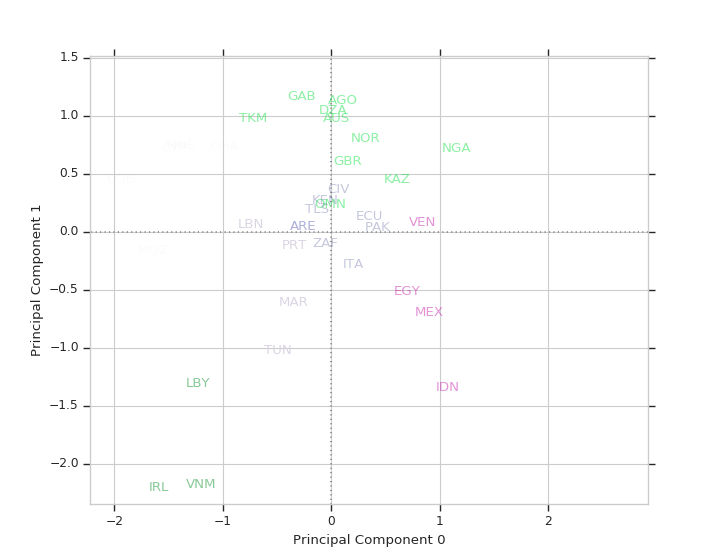

In [71]:
pc1=0
pc2=1
xlim=[-5, 5]
ylim=[-5, 5]
loadings=True
df_pc = data.df_pc
clab = data.clusterings_labels['kmeans10']
'''
Plot the countries along the two principal components given in input:
pc1[int] (usually = 0, indicating the first PC) and pc2[int]
'''
fig, ax1 = plt.subplots(figsize=(9, 7))

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

# build a generator of colors
cm = pylab.get_cmap('gist_rainbow')
NUM_COLORS = len(data.clusterings['kmeans10'])
# clist = [cm(*i/NUM_COLORS) for i in range(NUM_COLORS)]
# clist = [np.random.random(4) for i in range(NUM_COLORS)]
clist = np.random.uniform(low=0, high=1, size=(NUM_COLORS, 4))

# plot Principal Components pc1 and pc2
for i, country in enumerate(df_pc.index):
    ax1.annotate(country,
                 (df_pc[pc1].loc[country], -df_pc[pc2].loc[country]),
                 ha='center', color=clist[clab[i]])

# plot reference lines
ax1.hlines(0, -5, 5, linestyles='dotted', colors='grey')
ax1.vlines(0, -5, 5, linestyles='dotted', colors='grey')
pc1_string = 'Principal Component ' + str(pc1)
pc2_string = 'Principal Component ' + str(pc2)
ax1.set_xlabel(pc1_string)
ax1.set_ylabel(pc2_string)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'c': ['News',   'Hobbies & Interests',   'Arts & Entertainment',   'Internal Use',   'Business',   'Internal Use',   'Internal Use',   'Ad Impression Fraud',   'Arts & Entertainment',   'Adult Content',   'Arts & Entertainment',   'Internal Use',   'Internal Use',   'Reference',   'News',   'Shopping',   'Food & Drink',   'Internal Use',   'Internal Use',   'Reference'],  
'x': [-95.44078826904297,   127.71454620361328,   -491.93121337890625,   184.5579071044922,   -191.46273803710938,   95.22545623779297,   272.2229919433594,   -67.099365234375,   -317.60797119140625,   -175.90196228027344,   -491.93121337890625,   214.3858642578125,   184.5579071044922,   346.4012756347656,   -151.8809051513672,   431.6130676269531,   -299.4017028808594,   184.5579071044922,   184.5579071044922,   241.29026794433594],  
'y': [-40.87070846557617,   245.00514221191406,   43.07831954956055,   -458.2991638183594,   270.4497985839844,   -453.2981262207031,   -439.6551513671875,   -206.3104248046875,   205.25787353515625,   -58.520164489746094,   43.07831954956055,   -182.91664123535156,   -458.2991638183594,   19.559282302856445,   -281.3316650390625,   103.6922378540039,   280.2445373535156,   -458.2991638183594,   -458.2991638183594,   -113.96920776367188]})

df['col'] = df.c.astype('category').cat.codes

cmap = plt.cm.get_cmap('jet', df.c.nunique())
ax = df.plot.scatter(
    x='x',y='y', c='col',
    cmap=cmap
)
plt.show()